<a href="https://colab.research.google.com/github/claredavies/ImageIndexing/blob/main/MedicalImagingProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install neeeded packages (After running **RESTART RUNTIME**)

In [ ]:
!pip install pydicom
!pip install pylibjpeg
!pip install gdcm
!pip install pydicom[pylibjpeg]
!pip install python-gdcm
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg
!pip install pydicom pylibjpeg pylibjpeg-libjpeg
!pip install utils

# Loading need libraries

In [2]:
import os

import matplotlib
import pydicom
import numpy as np
import scipy
from matplotlib import pyplot as plt, animation
import zipfile
import cv2
from scipy.optimize import minimize

# Tutorial

In [ ]:
def median_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, :, img_dcm.shape[1]//2]    # Why //2?


def median_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, img_dcm.shape[2]//2, :]


def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)


def AIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the sagittal orientation. """
    return np.mean(img_dcm, axis=2)


def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=1)


def AIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the coronal orientation. """
    return np.mean(img_dcm, axis=1)


def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

How do you know the pixel_len_mm???

In [ ]:
dcm = pydicom.dcmread('1-1.dcm')     # Load DICOM file
print(dcm)                          # Print DICOM headers
pixel_len_mm = [3.27, 0.98, 0.98]   # Pixel length in mm [z, y, x]
img_dcm = dcm.pixel_array           # Get pixel array
img_dcm = np.flip(img_dcm, axis=0)  # Change orientation (better visualization)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 198
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.773.1600928601.639562
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Segmentation Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.773.1600928601.63956

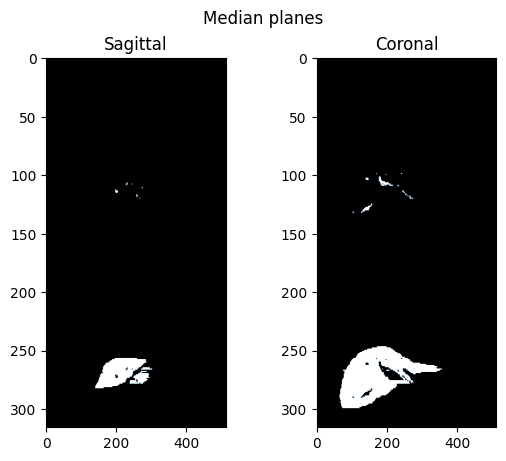

In [ ]:
# Show median planes
fig, ax = plt.subplots(1, 2)
ax[0].imshow(median_sagittal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('Sagittal')
ax[1].imshow(median_coronal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[2])
ax[1].set_title('Coronal')
fig.suptitle('Median planes')
plt.show()

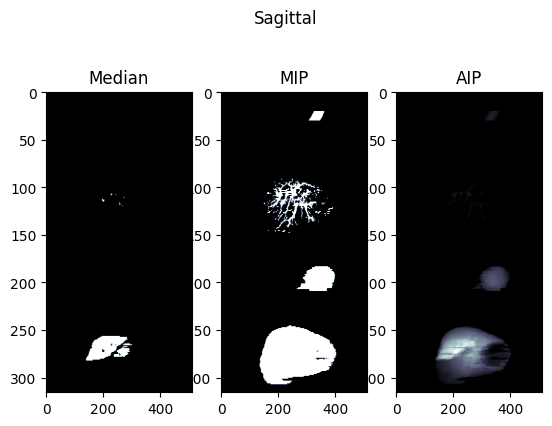

In [ ]:
# Show MIP/AIP/Median planes
fig, ax = plt.subplots(1, 3)
ax[0].imshow(median_sagittal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('Median')
ax[1].imshow(MIP_sagittal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1].set_title('MIP')
ax[2].imshow(AIP_sagittal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[2].set_title('AIP')
fig.suptitle('Sagittal')
plt.show()

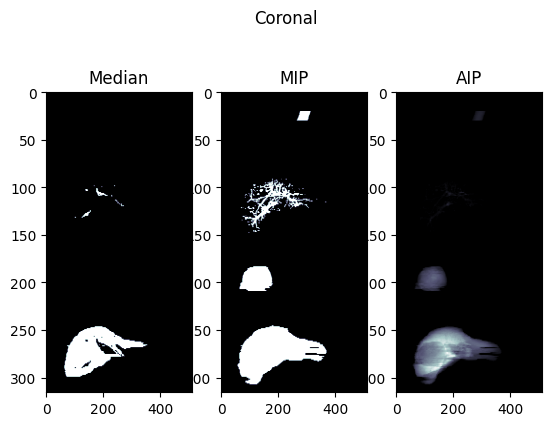

In [ ]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(median_coronal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('Median')
ax[1].imshow(MIP_coronal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1].set_title('MIP')
ax[2].imshow(AIP_coronal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[2].set_title('AIP')
fig.suptitle('Coronal')
plt.show()

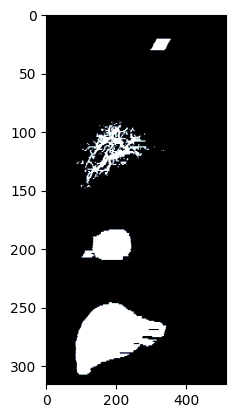

In [ ]:
# Create projections varying the angle of rotation
#   Configure visualization colormap
img_min = np.amin(img_dcm)
img_max = np.amax(img_dcm)
cm = matplotlib.colormaps['bone']
fig, ax = plt.subplots()
#   Configure directory to save results
os.makedirs('results/MIP/', exist_ok=True)
#   Create projections
n = 6
projections = []
for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(img_dcm, alpha)
    projection = MIP_sagittal_plane(rotated_img)
    plt.imshow(projection, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.savefig(f'results/MIP/Projection_{idx}.png')      # Save animation
    projections.append(projection)  # Save for later animation
# Save and visualize animation
animation_data = [
    [plt.imshow(img, animated=True, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])]
    for img in projections
]
anim = animation.ArtistAnimation(fig, animation_data,
                          interval=250, blit=True)
anim.save('results/MIP/Animation.gif')  # Save animation
plt.show() 

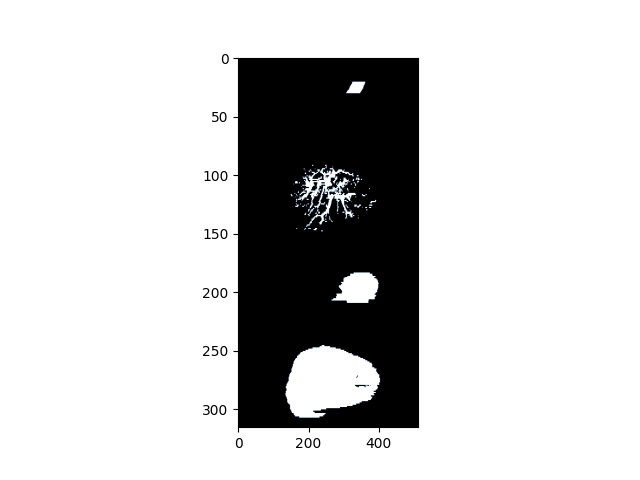

In [ ]:
from IPython.display import Image

# Provide the path to the GIF file
gif_path = 'results/MIP/Animation.gif'

# Display the GIF
Image(filename=gif_path)

# Making sense of headers

In [ ]:
def search_for_header_in_dcm(word_to_search, dcm):
  # Define the word to search for in the header names
  # Search for headers containing the specified word
  matching_headers = []
  for element in dcm:
      if word_to_search.lower() in element.name.lower():
          return True
          matching_headers.append(element.name)

  return False

In [ ]:
def is_single_acquisition_slice(dicom_file):
    if 'AcquisitionNumber' in dicom_file:
        acquisition_number = dicom_file.AcquisitionNumber
        if isinstance(acquisition_number, str):
            acquisition_number = int(acquisition_number)
            
        # Check if the AcquisitionNumber is 1, indicating a single acquisition slice
        if acquisition_number == 1:
            return True

        # if 'SliceIndex' in dicom_file:
        # slice_index = dicom_file.get('SliceIndex', None)
        # if slice_index is None:
        #     return False
        # return slice_index == 1
          
    return False

In [ ]:
def check_index_presence(image_files, segmentation_files):
    list_headers_to_find = ['Slice Index', 'Acquisition Number', 'Per-frame Functional Groups Sequence', 
                            'Image Position Patient', "Segment Identification Sequence", "Referenced Segment Number"]

    found_terms = []
    for dicom_file in image_files + segmentation_files:
        for term in list_headers_to_find:
          res = search_for_header_in_dcm(term, dicom_file)
          if res is True:
            list_headers_to_find.remove(term)
            found_terms.append(term)


    return found_terms

In [ ]:
def load_dicom_segmentation_files(zip_filename, extract_folder):
  # Extract DICOM files from the zip archive
  zip_file_path = zip_filename  

  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

  image_files = []
  segmentation_files = []
  for root, dirs, files in os.walk(extract_folder):
      for file in files:
          if file.endswith('.dcm'):
              dicom_file = pydicom.dcmread(os.path.join(root, file))
              if is_single_acquisition_slice(dicom_file):
                  image_files.append(dicom_file)
              else:
                  segmentation_files.append(dicom_file)

  return image_files, segmentation_files

In [ ]:
[image_files, segmentation_files] = load_dicom_segmentation_files('Archive.zip','file')

In [ ]:
[image_files, segmentation_files] = load_dicom_segmentation_files('HCC_004.zip')

In [ ]:
print(check_index_presence(image_files, segmentation_files))

['Acquisition Number', 'Per-frame Functional Groups Sequence']


In [ ]:
def get_header_value(dicom_file, header_name):
    try:
        header_value = dicom_file[header_name].value
    except KeyError:
        header_value = None
    return header_value

In [ ]:
def rearrange_pixel_arrays(image_files, segmentation_files):
     # Retrieve the relevant headers from each DICOM file
    # Retrieve the relevant headers from each DICOM file
     # Retrieve the relevant headers from each DICOM file
    image_headers = [dicom_file.get('AcquisitionNumber', None) for dicom_file in image_files]
    image_position_headers = [dicom_file.get('PerFrameFunctionalGroupsSequence', [{}])[0].get('ImagePositionPatient', None) for dicom_file in image_files]

    # Sort the DICOM files based on the headers
    sorted_image_files = [dicom_file for _, dicom_file in sorted(zip(image_headers, image_files), key=lambda x: x[0])]
    sorted_image_position_headers = [header for _, header in sorted(zip(image_headers, image_position_headers), key=lambda x: x[0])]

    # Create new lists to store the sorted DICOM files and corresponding pixel arrays
    sorted_images = []
    sorted_segmentations = []

    # Iterate through the sorted DICOM files and extract the pixel arrays
    for image_file, image_position_header in zip(sorted_image_files, sorted_image_position_headers):
        image_array = image_file.pixel_array

        # Perform further processing or analysis with the sorted image array

        sorted_images.append(image_array)

    for segmentation_file in segmentation_files:
        segmentation_array = segmentation_file.pixel_array

        # Perform further processing or analysis with the segmentation array

        sorted_segmentations.append(segmentation_array)

    return sorted_images, sorted_segmentations

In [ ]:
[sorted_images, sorted_segmentations] = rearrange_pixel_arrays(image_files, segmentation_files)

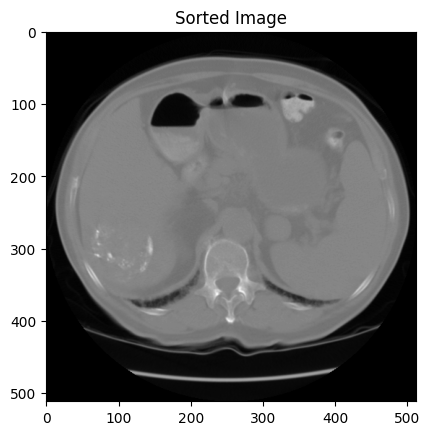

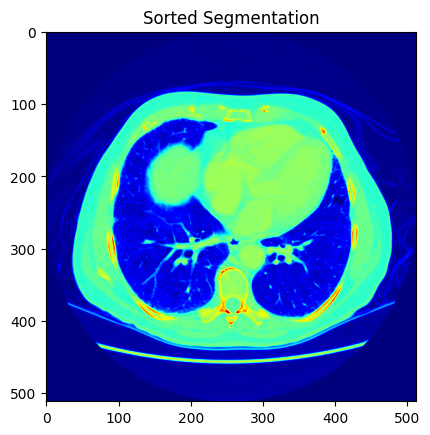

In [ ]:
import matplotlib.pyplot as plt

# Display one of the sorted images
plt.imshow(sorted_images[0], cmap='gray')
plt.title('Sorted Image')
plt.show()

# Display one of the sorted segmentations
plt.imshow(sorted_segmentations[0], cmap='jet')
plt.title('Sorted Segmentation')
plt.show()


# Co-register images

In [4]:
def coregister_images_landmarks(input_image, reference_image, input_landmarks, reference_landmarks):
    # Define the loss function
    def loss_function(params):
        # Extract translation and rotation parameters
        tx, ty, theta = params
        
        # Compute the transformation matrix
        transformation_matrix = np.array([[np.cos(theta), -np.sin(theta), tx],
                                          [np.sin(theta), np.cos(theta), ty]])
        
        # Apply the transformation to the input landmarks
        transformed_input_landmarks = cv2.transform(input_landmarks.reshape(-1, 1, 2), transformation_matrix).reshape(-1, 2)
        
        # Compute the Euclidean distance between the transformed input landmarks and the reference landmarks
        loss = np.linalg.norm(transformed_input_landmarks - reference_landmarks, axis=1).sum()
        
        return loss

    # Initialize the initial parameters for optimization
    initial_params = [0, 0, 0]  # Initial translation (tx, ty) and rotation angle (theta)

    # Use an optimizer to find the optimal parameters of the rigid motion
    result = minimize(loss_function, initial_params, method='Nelder-Mead')

    # Retrieve the optimal parameters
    optimal_params = result.x
    
    # Extract translation and rotation parameters
    tx, ty, theta = optimal_params
    
    # Compute the transformation matrix
    transformation_matrix = np.array([[np.cos(theta), -np.sin(theta), tx],
                                      [np.sin(theta), np.cos(theta), ty]])

    # Apply the transformation to the input image
    output_image = cv2.warpAffine(input_image, transformation_matrix, (reference_image.shape[1], reference_image.shape[0]))

    return output_image

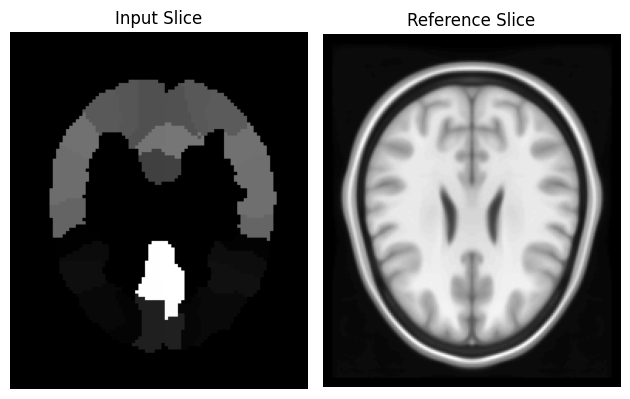

In [10]:
input_dcm = pydicom.dcmread("AAL3_1mm.dcm")
reference_dcm = pydicom.dcmread('icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm')

# Select a specific slice from the pixel data
input_slice_index = 100  # Adjust this value to the desired slice index
input_slice_data = input_dcm.pixel_array[input_slice_index]

# Select a specific slice from the pixel data
ref_slice_index = 100  # Adjust this value to the desired slice index
ref_slice_data = reference_dcm.pixel_array[ref_slice_index]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Display the input slice in the first subplot
axs[0].imshow(input_slice_data, cmap=plt.cm.gray)
axs[0].axis('off')  # Hide the axis ticks
axs[0].set_title('Input Slice')

# Display the reference slice in the second subplot
axs[1].imshow(ref_slice_data, cmap=plt.cm.gray)
axs[1].axis('off')  # Hide the axis ticks
axs[1].set_title('Reference Slice')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

In [46]:
import cv2
import numpy as np

def detect_landmarks(input_image, reference_image):
    # Convert the images to grayscale
    input_gray = input_image
    reference_gray = reference_image

    # Normalize the grayscale images
    input_gray_norm = cv2.normalize(input_gray, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    reference_gray_norm = cv2.normalize(reference_gray, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Compute the cross-correlation using the normalized grayscale images
    cross_correlation = cv2.matchTemplate(input_gray_norm, reference_gray_norm, cv2.TM_CCORR_NORMED)

    # Find the peak locations in the cross-correlation map
    _, _, _, max_loc = cv2.minMaxLoc(cross_correlation)

    # Extract the landmark coordinates as the peak locations
    input_landmarks = np.array([max_loc])

    # Since we have only one landmark, repeat it for the number of keypoints
    num_keypoints = input_landmarks.shape[0]
    reference_landmarks = np.repeat(input_landmarks, num_keypoints, axis=0)

    # Draw the landmarks on both images
    input_image_with_landmarks = cv2.cvtColor(input_gray, cv2.COLOR_GRAY2BGR)
    reference_image_with_landmarks = cv2.cvtColor(reference_gray, cv2.COLOR_GRAY2BGR)

    for landmark in input_landmarks:
        cv2.drawMarker(input_image_with_landmarks, tuple(landmark), (0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2)

    for landmark in reference_landmarks:
        cv2.drawMarker(reference_image_with_landmarks, tuple(landmark), (0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2)

    return input_landmarks, reference_landmarks, input_image_with_landmarks, reference_image_with_landmarks


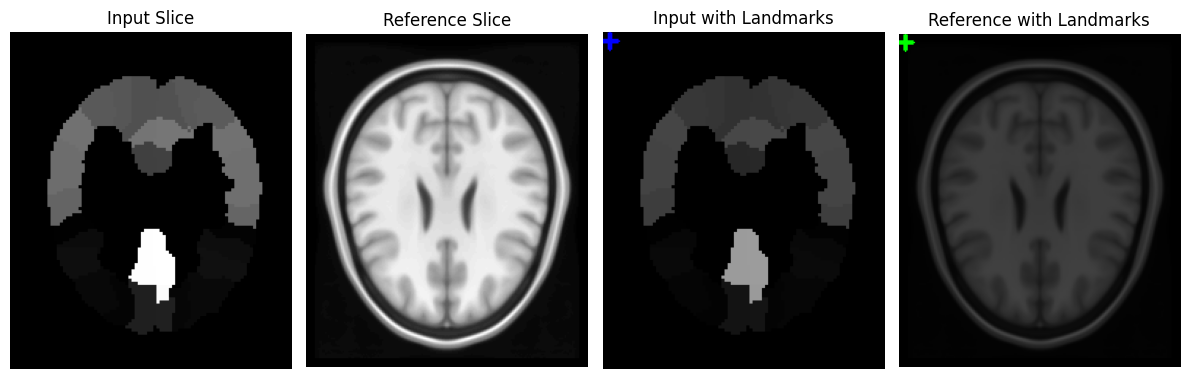

In [47]:
# Call detect_landmarks function
input_landmarks, reference_landmarks, input_image_with_landmarks, reference_image_with_landmarks = detect_landmarks(input_slice_data, ref_slice_data)

# Create a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Display input_slice_data
axs[0].imshow(input_slice_data, cmap=plt.cm.gray)
axs[0].axis('off')
axs[0].set_title('Input Slice')

# Display ref_slice_data
axs[1].imshow(ref_slice_data, cmap=plt.cm.gray)
axs[1].axis('off')
axs[1].set_title('Reference Slice')

# Display input_image_with_landmarks
axs[2].imshow(input_image_with_landmarks, cmap=plt.cm.gray)
axs[2].axis('off')
axs[2].set_title('Input with Landmarks')

# Display reference_image_with_landmarks
axs[3].imshow(reference_image_with_landmarks, cmap=plt.cm.gray)
axs[3].axis('off')
axs[3].set_title('Reference with Landmarks')

plt.tight_layout()  # Adjust the layout
plt.show()

In [ ]:
# Example usage
input_image = cv2.imread('input_image.jpg', 0)  # Load input image in grayscale
reference_image = cv2.imread('reference_image.jpg', 0)  # Load reference image in grayscale

# Define corresponding landmarks in input and reference images
input_landmarks = np.array([[x1, y1], [x2, y2], [x3, y3], ...])  # Specify input landmarks (x, y) coordinates
reference_landmarks = np.array([[x1, y1], [x2, y2], [x3, y3], ...])  # Specify reference landmarks (x, y) coordinates

# Coregister the images using landmarks and optimization
coregistered_image = coregister_images_landmarks(input_image, reference_image, input_landmarks, reference_landmarks)

# Display the coregistered image
cv2.imshow('Coregistered Image', coregistered_image)
cv2.waitKey(0)
cv2.destroyAllWindows()